In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import statsmodels.api as sm
from linearmodels import PanelOLS
import copy

In [2]:
pubs_author_funder = pd.read_csv("..//..//..//data//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [3]:
pubs_author_funder['author_distinct']=pubs_author_funder['author_country'].apply(
    lambda x:list(set(x)))
pubs_author_funder['funder_distinct']=pubs_author_funder['funder_country'].apply(
    lambda x:list(set(x)))


In [4]:
author_df=pubs_author_funder[['id','author_distinct','discipline','year']]
author_df=author_df.explode('author_distinct')
author_df.head()

,id,author_distinct,discipline,year
0,30507292,Turkey,77,2009
1,30574690,United States,83,2009
1,30574690,France,83,2009
2,30574691,Russia,83,2009
3,30585095,Spain,89,2009


In [5]:
from itertools import tee

def window(iterable, size):
    iters = tee(iterable, size)
    for i in range(1, size):
        for each in iters[i:]:
            next(each, None)
    return zip(*iters)

In [8]:
def get_cntry_dis_year(data,year):
    cntry_dis_year=data[data.year.isin(year)]
    cntry_dis_year=cntry_dis_year.groupby(['author_distinct','discipline']).agg(
        {'id':'size'}).reset_index()
    cntry_dis_year.columns=['country','discipline','numpubs']
    #cntry_dis_year['numpubs']=cntry_dis_year['numpubs']/len(year)
    return cntry_dis_year

In [9]:
def get_cntry_dis(data, start_year, end_year):
    data_start=get_cntry_dis_year(data,start_year)
    data_end=get_cntry_dis_year(data,end_year)
    data_all=data_start.merge(data_end,on=['country','discipline'],how="inner")
    return data_all

In [10]:
def construct_windowdata(data,yearwindow, func):
    windowdata=pd.DataFrame()
    for index, years in enumerate(yearwindow):
        start=years[0:3]
        end=years[3:]
        data_all=func(data,start, end)
        data_all['time']=index
        windowdata=pd.concat([windowdata,data_all])
    return windowdata

In [8]:
def get_units(data, start, end):
    data_filter=data[data.year.isin(start)]
    # units the country recieved from itself
    unit_dom=data_filter.query('source == target')
    unit_dom = unit_dom.groupby(
        ['target','discipline'])['unit'].sum().reset_index()
    unit_dom.columns=['country','discipline','dom_unit']
    # units the country recieved from other countries
    unit_for = data_filter.query('source != target')
    unit_fromfor = unit_for.groupby(
        ['target','discipline'])['unit'].sum().reset_index()
    unit_fromfor.columns=['country','discipline','for_unit']
    # units the country provides to other countries
    unit2for=unit_for.groupby(
        ['source','discipline'])['unit'].sum().reset_index()
    unit2for.columns=['country','discipline','unit2for']
    
    cntry_dis_unit=unit_dom.merge(unit_fromfor, on=['country','discipline'],how='outer')
    cntry_dis_unit=cntry_dis_unit.merge(unit2for, on=['country','discipline'],how='outer')
    return cntry_dis_unit

In [14]:
yearwindow= window(np.arange(2009,2019), 6)
for item in yearwindow:
    print(item)

(2009, 2010, 2011, 2012, 2013, 2014)
(2010, 2011, 2012, 2013, 2014, 2015)
(2011, 2012, 2013, 2014, 2015, 2016)
(2012, 2013, 2014, 2015, 2016, 2017)
(2013, 2014, 2015, 2016, 2017, 2018)


In [11]:
yearwindow= window(np.arange(2009,2019), 6)
cntry_dis=construct_windowdata(author_df,yearwindow,get_cntry_dis)

In [12]:
cntry_cntry_dis_df=pd.read_csv("..//..//..//data//Data//DerivedData//Derived//funding_source_target_dis.csv")
cntry_cntry_dis_df.head()

,source,target,year,discipline,unit
0,Afghanistan,Afghanistan,2010,66,0.500000
1,Afghanistan,Australia,2018,69,0.333333
2,Afghanistan,Bangladesh,2011,47,0.666667
3,Afghanistan,Bolivia,2016,71,0.125000
4,Afghanistan,Canada,2015,71,0.333333


In [11]:
yearwindow= window(np.arange(2009,2019), 6)
cntry_dis_unit=construct_windowdata(cntry_cntry_dis_df, yearwindow, get_units)
cntry_dis_unit

,country,discipline,dom_unit,for_unit,unit2for,time
0,Afghanistan,66,0.500000,NaN,0.500000,0
1,Albania,1,0.666667,4.666667,1.333333,0
2,Albania,39,0.500000,NaN,0.500000,0
3,Albania,69,1.250000,2.166667,0.750000,0
4,Algeria,1,8.933333,7.250866,11.066667,0
...,...,...,...,...,...,...
12078,Yemen,4,NaN,NaN,1.000000,4
12079,Yemen,13,NaN,NaN,1.000000,4
12080,Zambia,84,NaN,NaN,3.000000,4
12081,Zimbabwe,78,NaN,NaN,1.000000,4


In [12]:
metadata=cntry_dis.merge(cntry_dis_unit,on=['country','discipline','time'])
metadata=metadata.fillna(0)
metadata

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for
0,Afghanistan,1,4,5,0,0.000000,1.333333,0.000000
1,Afghanistan,4,2,2,0,0.000000,0.666667,0.000000
2,Afghanistan,25,2,2,0,0.000000,0.125000,0.000000
3,Afghanistan,35,1,1,0,0.000000,2.000000,0.000000
4,Afghanistan,44,10,21,0,0.000000,2.550000,0.000000
...,...,...,...,...,...,...,...,...
54212,Zimbabwe,85,15,24,4,1.500000,2.000000,0.500000
54213,Zimbabwe,88,11,11,4,0.583333,3.666667,1.416667
54214,Zimbabwe,89,3,10,4,0.000000,1.000000,0.000000
54215,Zimbabwe,93,2,2,4,0.000000,0.700000,0.000000


## Add collaboration into consideration

In [13]:
pubs_author_funder.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [13]:
coll_df=pubs_author_funder[['id','author_country','discipline','year']]
coll_df['coll']=coll_df['author_country'].apply(
    lambda x:1 if (len(x)>1 and len(set(x))==1) else 0)
coll_df['int_coll']=coll_df['author_country'].apply(lambda x: 1 if len(set(x))>1 else 0)
coll_df.head()

<ipython-input-13-7073c20fe3d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coll_df['coll']=coll_df['author_country'].apply(
<ipython-input-13-7073c20fe3d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coll_df['int_coll']=coll_df['author_country'].apply(lambda x: 1 if len(set(x))>1 else 0)


,id,author_country,discipline,year,coll,int_coll
0,30507292,[Turkey],77,2009,0,0
1,30574690,"[United States, France]",83,2009,0,1
2,30574691,[Russia],83,2009,0,0
3,30585095,"[Spain, Spain]",89,2009,1,0
4,30585097,"[Germany, Spain]",89,2009,0,1


In [14]:
coll_df['author_country']=coll_df['author_country'].apply(lambda x:list(set(x)))
coll_df=coll_df.explode('author_country')
coll_df.head()

<ipython-input-14-5db62008c8ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coll_df['author_country']=coll_df['author_country'].apply(lambda x:list(set(x)))


,id,author_country,discipline,year,coll,int_coll
0,30507292,Turkey,77,2009,0,0
1,30574690,France,83,2009,0,1
1,30574690,United States,83,2009,0,1
2,30574691,Russia,83,2009,0,0
3,30585095,Spain,89,2009,1,0


In [15]:
def get_coll_ratio(data, start, end):
    data_filter=data[data.year.isin(start)]
    data_filter = data_filter.groupby(['author_country','discipline']).agg(
    {'id':'size','coll':'sum','int_coll':'sum'}).reset_index()
    data_filter.columns=['country','discipline','numpubs','dom_coll','int_coll']
    data_filter['dom_coll']=data_filter['dom_coll']
    data_filter['int_coll']=data_filter['int_coll']
    return data_filter

In [16]:
yearwindow= window(np.arange(2009,2019), 6)
cntry_dis_coll = construct_windowdata(coll_df,yearwindow,get_coll_ratio)
cntry_dis_coll.head()

,country,discipline,numpubs,dom_coll,int_coll,time
0,Afghanistan,1,4,0,3,0
1,Afghanistan,2,2,0,2,0
2,Afghanistan,3,3,0,3,0
3,Afghanistan,4,2,1,1,0
4,Afghanistan,19,2,0,2,0


In [17]:
cntry_fund = pubs_author_funder[[
    'id','author_country','funder_country','discipline','year']]
cntry_fund=cntry_fund[cntry_fund.funder_country!='Not-Funded']
cntry_fund['author_country']=cntry_fund['author_country'].apply(
    lambda x:list(set(x)))
cntry_fund['funder_country']=cntry_fund['funder_country'].apply(
    lambda x:list(set(x)))
cntry_fund=cntry_fund.explode('funder_country')
cntry_fund

,id,author_country,funder_country,discipline,year
0,30507292,[Turkey],Turkey,77,2009
1,30574690,"[France, United States]",United States,83,2009
2,30574691,[Russia],Russia,83,2009
3,30585095,[Spain],Spain,89,2009
4,30585097,"[Spain, Germany]",Spain,89,2009
...,...,...,...,...,...
7739778,65301284,"[Turkey, Canada]",Turkey,61,2016
7739778,65301284,"[Turkey, Canada]",Canada,61,2016
7739779,65301319,[China],China,14,2018
7739780,65301320,"[Russia, Ukraine, United Kingdom]",United Kingdom,28,2017


In [18]:
def assign_fund2for(authorlist,funder):
    if (len(authorlist)==1) and (authorlist[0]==funder):
        return 0
    else:
        return 1
cntry_fund['fund2for']=cntry_fund[['author_country','funder_country']].apply(
    lambda x:assign_fund2for(x['author_country'],x['funder_country']),axis=1)
cntry_fund.head()

,id,author_country,funder_country,discipline,year,fund2for
0,30507292,[Turkey],Turkey,77,2009,0
1,30574690,"[France, United States]",United States,83,2009,1
2,30574691,[Russia],Russia,83,2009,0
3,30585095,[Spain],Spain,89,2009,0
4,30585097,"[Spain, Germany]",Spain,89,2009,1


In [19]:
def get_pubcount_fund2foreign(data,start, end):
    data_filter=data[data.year.isin(start)]
    cntry_pubcount_2for=data_filter.groupby(
        ['funder_country','discipline'])['fund2for'].sum().reset_index()
    cntry_pubcount_2for.columns=['country','discipline','pubcount_2for']
    return cntry_pubcount_2for

In [20]:
yearwindow= window(np.arange(2009,2019), 6)
cntry_pubcount_2for=construct_windowdata(cntry_fund, yearwindow, get_pubcount_fund2foreign)
cntry_pubcount_2for.head()

,country,discipline,pubcount_2for,time
0,Afghanistan,47,1,0
1,Afghanistan,66,1,0
2,Albania,1,2,0
3,Albania,39,1,0
4,Albania,69,2,0


In [21]:
metadata=metadata.merge(cntry_pubcount_2for, on=['country','discipline','time'],how='left')
metadata.head()

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for
0,Afghanistan,1,4,5,0,0.0,1.333333,0.0,NaN
1,Afghanistan,4,2,2,0,0.0,0.666667,0.0,NaN
2,Afghanistan,25,2,2,0,0.0,0.125000,0.0,NaN
3,Afghanistan,35,1,1,0,0.0,2.000000,0.0,NaN
4,Afghanistan,44,10,21,0,0.0,2.550000,0.0,NaN


In [22]:
metadata=metadata.merge(cntry_dis_coll, on=['country','discipline','time'], how='left')
metadata

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for,numpubs,dom_coll,int_coll
0,Afghanistan,1,4,5,0,0.000000,1.333333,0.000000,NaN,4,0,3
1,Afghanistan,4,2,2,0,0.000000,0.666667,0.000000,NaN,2,1,1
2,Afghanistan,25,2,2,0,0.000000,0.125000,0.000000,NaN,2,0,2
3,Afghanistan,35,1,1,0,0.000000,2.000000,0.000000,NaN,1,0,0
4,Afghanistan,44,10,21,0,0.000000,2.550000,0.000000,NaN,10,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
54212,Zimbabwe,85,15,24,4,1.500000,2.000000,0.500000,1.0,15,2,6
54213,Zimbabwe,88,11,11,4,0.583333,3.666667,1.416667,2.0,11,0,6
54214,Zimbabwe,89,3,10,4,0.000000,1.000000,0.000000,NaN,3,0,3
54215,Zimbabwe,93,2,2,4,0.000000,0.700000,0.000000,NaN,2,0,2


In [23]:
metadata=metadata.fillna(0)
metadata.head()

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for,numpubs,dom_coll,int_coll
0,Afghanistan,1,4,5,0,0.0,1.333333,0.0,0.0,4,0,3
1,Afghanistan,4,2,2,0,0.0,0.666667,0.0,0.0,2,1,1
2,Afghanistan,25,2,2,0,0.0,0.125000,0.0,0.0,2,0,2
3,Afghanistan,35,1,1,0,0.0,2.000000,0.0,0.0,1,0,0
4,Afghanistan,44,10,21,0,0.0,2.550000,0.0,0.0,10,0,10


In [24]:
cntry_author=pubs_author_funder[['id','author_country','funder_country','discipline','year']]
cntry_author=cntry_author[cntry_author.funder_country!='Not-Funded']
cntry_author['author_country']=cntry_author['author_country'].apply(
    lambda x:list(set(x)))
cntry_author['funder_country']=cntry_author['funder_country'].apply(
    lambda x:list(set(x)))
cntry_author=cntry_author.explode('author_country')
cntry_author.head()

,id,author_country,funder_country,discipline,year
0,30507292,Turkey,[Turkey],77,2009
1,30574690,France,[United States],83,2009
1,30574690,United States,[United States],83,2009
2,30574691,Russia,[Russia],83,2009
3,30585095,Spain,[Spain],89,2009


In [25]:
def label_domes(author, funderlist):
    if author in funderlist:
        return 1
    else:
        return 0
def label_forei(author, funderlist):
    if (len(funderlist)==1) and (funderlist[0]==author):
        return 0
    else:
        return 1
cntry_author['domes_count']=cntry_author[['author_country','funder_country']].apply(
    lambda x:label_domes(x.author_country,x.funder_country),axis=1)
cntry_author['forei_count']=cntry_author[['author_country','funder_country']].apply(
    lambda x:label_forei(x.author_country,x.funder_country),axis=1)
cntry_author

,id,author_country,funder_country,discipline,year,domes_count,forei_count
0,30507292,Turkey,[Turkey],77,2009,1,0
1,30574690,France,[United States],83,2009,0,1
1,30574690,United States,[United States],83,2009,1,0
2,30574691,Russia,[Russia],83,2009,1,0
3,30585095,Spain,[Spain],89,2009,1,0
...,...,...,...,...,...,...,...
7739779,65301319,China,[China],14,2018,1,0
7739780,65301320,Russia,[United Kingdom],28,2017,0,1
7739780,65301320,Ukraine,[United Kingdom],28,2017,0,1
7739780,65301320,United Kingdom,[United Kingdom],28,2017,1,0


In [26]:
def get_pbcnt_byfundtype(data, start, end):
    data_filter=data[data.year.isin(start)]
    pbcnt_domes=data_filter.groupby(['author_country','discipline'])['domes_count'].sum().reset_index()
    pbcnt_domes.columns=['country','discipline','domes_count']
    pbcnt_forei=data_filter.groupby(['author_country','discipline'])['forei_count'].sum().reset_index()
    pbcnt_forei.columns=['country','discipline','forei_count']
    pbcnt_df=pbcnt_forei.merge(pbcnt_domes,on=['country','discipline'])
    return pbcnt_df

In [27]:
yearwindow= window(np.arange(2009,2019), 6)
cntry_pbcnt_fundtype=construct_windowdata(cntry_author, yearwindow, get_pbcnt_byfundtype)
cntry_pbcnt_fundtype.head()

,country,discipline,forei_count,domes_count,time
0,Afghanistan,1,3,0,0
1,Afghanistan,3,1,0,0
2,Afghanistan,4,1,0,0
3,Afghanistan,25,1,0,0
4,Afghanistan,35,1,0,0


In [28]:
metadata=metadata.merge(cntry_pbcnt_fundtype,on=['country','discipline','time'],how="left")
metadata.head()

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for,numpubs,dom_coll,int_coll,forei_count,domes_count
0,Afghanistan,1,4,5,0,0.0,1.333333,0.0,0.0,4,0,3,3.0,0.0
1,Afghanistan,4,2,2,0,0.0,0.666667,0.0,0.0,2,1,1,1.0,0.0
2,Afghanistan,25,2,2,0,0.0,0.125000,0.0,0.0,2,0,2,1.0,0.0
3,Afghanistan,35,1,1,0,0.0,2.000000,0.0,0.0,1,0,0,1.0,0.0
4,Afghanistan,44,10,21,0,0.0,2.550000,0.0,0.0,10,0,10,4.0,0.0


In [29]:
metadata.to_csv("metadata.csv",index=False)

In [30]:
metadata['dom_unit_avg'] = metadata['dom_unit']/metadata['domes_count']
metadata['foreign_unit_avg']=metadata['for_unit']/metadata['forei_count']
metadata['unit2for_avg']=metadata['unit2for']/metadata['pubcount_2for']
metadata['dom_coll_ratio']=metadata['dom_coll']/metadata['numpubs']
metadata['int_coll_ratio']=metadata['int_coll']/metadata['numpubs']

In [31]:
metadata.head()

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for,numpubs,dom_coll,int_coll,forei_count,domes_count,dom_unit_avg,foreign_unit_avg,unit2for_avg,dom_coll_ratio,int_coll_ratio
0,Afghanistan,1,4,5,0,0.0,1.333333,0.0,0.0,4,0,3,3.0,0.0,NaN,0.444444,NaN,0.0,0.75
1,Afghanistan,4,2,2,0,0.0,0.666667,0.0,0.0,2,1,1,1.0,0.0,NaN,0.666667,NaN,0.5,0.50
2,Afghanistan,25,2,2,0,0.0,0.125000,0.0,0.0,2,0,2,1.0,0.0,NaN,0.125000,NaN,0.0,1.00
3,Afghanistan,35,1,1,0,0.0,2.000000,0.0,0.0,1,0,0,1.0,0.0,NaN,2.000000,NaN,0.0,0.00
4,Afghanistan,44,10,21,0,0.0,2.550000,0.0,0.0,10,0,10,4.0,0.0,NaN,0.637500,NaN,0.0,1.00


In [78]:
collist=['country','discipline','time','numpubs_x','numpubs_y','dom_coll','int_coll',
        'dom_unit_avg','foreign_unit_avg','unit2for_avg']
metadata=metadata[collist]

In [32]:
metadata['pub_growth']=np.log10(metadata['numpubs_y']/metadata['numpubs_x'])
metadata=metadata.fillna(0)
metadata.head()

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for,numpubs,dom_coll,int_coll,forei_count,domes_count,dom_unit_avg,foreign_unit_avg,unit2for_avg,dom_coll_ratio,int_coll_ratio,pub_growth
0,Afghanistan,1,4,5,0,0.0,1.333333,0.0,0.0,4,0,3,3.0,0.0,0.0,0.444444,0.0,0.0,0.75,0.096910
1,Afghanistan,4,2,2,0,0.0,0.666667,0.0,0.0,2,1,1,1.0,0.0,0.0,0.666667,0.0,0.5,0.50,0.000000
2,Afghanistan,25,2,2,0,0.0,0.125000,0.0,0.0,2,0,2,1.0,0.0,0.0,0.125000,0.0,0.0,1.00,0.000000
3,Afghanistan,35,1,1,0,0.0,2.000000,0.0,0.0,1,0,0,1.0,0.0,0.0,2.000000,0.0,0.0,0.00,0.000000
4,Afghanistan,44,10,21,0,0.0,2.550000,0.0,0.0,10,0,10,4.0,0.0,0.0,0.637500,0.0,0.0,1.00,0.322219


In [44]:
metadata.head()

discipline  numpubs_x  numpubs_y  dom_unit  for_unit  \
country     time                                                         
Afghanistan 0              1          4          5       0.0  1.333333   
            0             25          2          2       0.0  0.125000   
            0             44         10         21       0.0  2.550000   
            0             46          1          4       0.0  0.750000   
            0             48          6          6       0.0  1.300000   

                  unit2for  pubcount_2for  numpubs  dom_coll  int_coll  ...  \
country     time                                                        ...   
Afghanistan 0          0.0            0.0        4         0         3  ...   
            0          0.0            0.0        2         0         2  ...   
            0          0.0            0.0       10         0        10  ...   
            0          0.0            0.0        1         0         1  ...   
            0          0.0            0.0        6         0         5  ...   

                  foreign_unit_avg  unit2for_avg  dom_coll_ratio  \
country     time                                                   
Afghanistan 0             0.444444           0.0             0.0   
            0             0.125000           0.0             0.0   
            0             0.637500           0.0             0.0   
            0             0.750000           0.0             0.0   
            0             0.433333           0.0             0.0   

                  int_coll_ratio  pub_growth  numpubs_x_log  dom_unit_log  \
country     time                                                            
Afghanistan 0           0.750000    0.096910       0.602060           0.0   
            0           1.000000    0.000000       0.301030           0.0   
            0           1.000000    0.322219       1.000000           0.0   
            0           1.000000    0.602060       0.000000           0.0   
            0           0.833333    0.000000       0.778151           0.0   

                  for_unit_log  unit2for_log  timesize  
country     time                                        
Afghanistan 0         0.367977           0.0         5  
            0         0.051153           0.0         5  
            0         0.550228           0.0         5  
            0         0.243038           0.0         5  
            0         0.361728           0.0         5  

[5 rows x 23 columns]

In [33]:
metadata['numpubs_x_log']=np.log10(metadata['numpubs_x'])
metadata['dom_unit_log']=np.log10(metadata['dom_unit']+1)
metadata['for_unit_log']=np.log10(metadata['for_unit']+1)
metadata['unit2for_log']=np.log10(metadata['unit2for']+1)
metadata['dom_coll_log']=np.log10(metadata['dom_coll']+1)
metadata['int_coll_log']=np.log10(metadata['int_coll']+1)

In [34]:
metadata['timesize'] = metadata.groupby(['country','discipline'])['time'].transform('size')
metadata=metadata[metadata.timesize==5]
metadata.head()

,country,discipline,numpubs_x,numpubs_y,time,dom_unit,for_unit,unit2for,pubcount_2for,numpubs,...,dom_coll_ratio,int_coll_ratio,pub_growth,numpubs_x_log,dom_unit_log,for_unit_log,unit2for_log,dom_coll_log,int_coll_log,timesize
0,Afghanistan,1,4,5,0,0.0,1.333333,0.0,0.0,4,...,0.0,0.750000,0.096910,0.602060,0.0,0.367977,0.0,0.0,0.602060,5
2,Afghanistan,25,2,2,0,0.0,0.125000,0.0,0.0,2,...,0.0,1.000000,0.000000,0.301030,0.0,0.051153,0.0,0.0,0.477121,5
4,Afghanistan,44,10,21,0,0.0,2.550000,0.0,0.0,10,...,0.0,1.000000,0.322219,1.000000,0.0,0.550228,0.0,0.0,1.041393,5
5,Afghanistan,46,1,4,0,0.0,0.750000,0.0,0.0,1,...,0.0,1.000000,0.602060,0.000000,0.0,0.243038,0.0,0.0,0.301030,5
7,Afghanistan,48,6,6,0,0.0,1.300000,0.0,0.0,6,...,0.0,0.833333,0.000000,0.778151,0.0,0.361728,0.0,0.0,0.778151,5


In [35]:
metadata = metadata.sort_values(by=['country','time','discipline']).set_index(['country','time'])

In [41]:
metadata.head()

discipline  numpubs_x  numpubs_y  dom_unit  for_unit  \
country     time                                                         
Afghanistan 0              1          4          5       0.0  1.333333   
            0             25          2          2       0.0  0.125000   
            0             44         10         21       0.0  2.550000   
            0             46          1          4       0.0  0.750000   
            0             48          6          6       0.0  1.300000   

                  unit2for  pubcount_2for  numpubs  dom_coll  int_coll  ...  \
country     time                                                        ...   
Afghanistan 0          0.0            0.0        4         0         3  ...   
            0          0.0            0.0        2         0         2  ...   
            0          0.0            0.0       10         0        10  ...   
            0          0.0            0.0        1         0         1  ...   
            0          0.0            0.0        6         0         5  ...   

                  foreign_unit_avg  unit2for_avg  dom_coll_ratio  \
country     time                                                   
Afghanistan 0             0.444444           0.0             0.0   
            0             0.125000           0.0             0.0   
            0             0.637500           0.0             0.0   
            0             0.750000           0.0             0.0   
            0             0.433333           0.0             0.0   

                  int_coll_ratio  pub_growth  numpubs_x_log  dom_unit_log  \
country     time                                                            
Afghanistan 0           0.750000    0.096910       0.602060           0.0   
            0           1.000000    0.000000       0.301030           0.0   
            0           1.000000    0.322219       1.000000           0.0   
            0           1.000000    0.602060       0.000000           0.0   
            0           0.833333    0.000000       0.778151           0.0   

                  for_unit_log  unit2for_log  timesize  
country     time                                        
Afghanistan 0         0.367977           0.0         5  
            0         0.051153           0.0         5  
            0         0.550228           0.0         5  
            0         0.243038           0.0         5  
            0         0.361728           0.0         5  

[5 rows x 23 columns]

In [36]:
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS

In [78]:
metadata = metadata.rename(columns={"numpubs_x_log": "NumPub_t", "dom_unit_log": "DomesUnits",'for_unit_log':'ForeiUnits',
                        "dom_coll_log":"DomesColl",'int_coll_log':'IntColl','rel_citation_x':'citation_t','rel_citation_y':'citation_t+1',
                                   "singlefund_log":"SingleFund",'cofund_log':'IntFund'})
metadata.head()

discipline  numpubs_x  citation_t  numpubs_y  citation_t+1  \
country     time                                                               
Afghanistan 0              1          4    0.369000          5      0.299800   
            1              1          5    0.342400          4      0.315750   
            2              1          7    0.410143          7      1.433857   
            3              1          5    0.299800          8      1.834250   
            4              1          4    0.315750         15      1.309667   

                  dom_unit  for_unit  numpubs  dom_coll  int_coll  ...  \
country     time                                                   ...   
Afghanistan 0          0.0  1.333333        4         0         3  ...   
            1          0.0  1.833333        5         0         4  ...   
            2          0.0  3.000000        7         0         6  ...   
            3          0.0  1.666667        5         0         5  ...   
            4          0.0  1.166667        4         0         4  ...   

                  timesize  pub_growth  NumPub_t  DomesUnits  ForeiUnits  \
country     time                                                           
Afghanistan 0            5    0.096910  0.602060         0.0    0.367977   
            1            5   -0.096910  0.698970         0.0    0.452298   
            2            5    0.000000  0.845098         0.0    0.602060   
            3            5    0.204120  0.698970         0.0    0.425969   
            4            5    0.574031  0.602060         0.0    0.335792   

                  numpubs_y_log  DomesColl   IntColl  SingleFund  IntFund  
country     time                                                           
Afghanistan 0          0.698970        0.0  0.602060         0.0      0.0  
            1          0.602060        0.0  0.698970         0.0      0.0  
            2          0.845098        0.0  0.845098         0.0      0.0  
            3          0.903090        0.0  0.778151         0.0      0.0  
            4          1.176091        0.0  0.698970         0.0      0.0  

[5 rows x 22 columns]

In [249]:
cntry_num=author_df.groupby(['author_country'])['id'].size().reset_index()
cntrylist = cntry_num.sort_values(by='id',ascending=False)[2:].author_country.tolist()


In [49]:
test = copy.deepcopy(metadata)
test=test.reset_index()
test=test[(test.numpubs_x>20)]
test['timesize'] = test.groupby(['country','discipline'])['time'].transform('size')
test=test[test.timesize==5]
test = test.sort_values(by=['country','discipline','time']).set_index(['country','time'])

In [41]:
test.head()

discipline  numpubs_x  numpubs_y  dom_unit  for_unit  unit2for  \
country time                                                                   
Albania 0             69         63         93      1.25  2.166667      0.75   
        1             69         87         84      2.25  3.833333      0.75   
        2             69         91         95      1.75  3.166667      0.25   
        3             69         93         69      3.00  6.983333      1.00   
        4             69         84         58      2.00  6.316667      1.00   

              pubcount_2for  numpubs  dom_coll  int_coll  ...  \
country time                                              ...   
Albania 0               2.0       63        18        16  ...   
        1               2.0       87        25        23  ...   
        2               1.0       91        25        23  ...   
        3               2.0       93        29        31  ...   
        4               2.0       84        27        35  ...   

              foreign_unit_avg  unit2for_avg  dom_coll_ratio  int_coll_ratio  \
country time                                                                   
Albania 0             0.722222         0.375        0.285714        0.253968   
        1             0.766667         0.375        0.287356        0.264368   
        2             0.791667         0.250        0.274725        0.252747   
        3             0.698333         0.500        0.311828        0.333333   
        4             0.631667         0.500        0.321429        0.416667   

              pub_growth  numpubs_x_log  dom_unit_log  for_unit_log  \
country time                                                          
Albania 0       0.169142       1.799341      0.352183      0.500602   
        1      -0.015240       1.939519      0.511883      0.684247   
        2       0.018682       1.959041      0.439333      0.619789   
        3      -0.129634       1.968483      0.602060      0.902184   
        4      -0.160851       1.924279      0.477121      0.864313   

              unit2for_log  timesize  
country time                          
Albania 0         0.243038         5  
        1         0.243038         5  
        2         0.096910         5  
        3         0.301030         5  
        4         0.301030         5  

[5 rows x 23 columns]

In [136]:
metadata.head()

discipline  numpubs_x  rel_citation_x  numpubs_y  \
country     time                                                     
Afghanistan 0              1          4        0.369000          5   
            0             25          2        2.318500          2   
            0             44         10        0.693600         21   
            0             46          1        0.298000          4   
            0             48          6        0.272333          6   

                  rel_citation_y  dom_unit  for_unit  unit2for  pubcount_2for  \
country     time                                                                
Afghanistan 0           0.299800       0.0  1.333333       0.0            0.0   
            0           0.552500       0.0  0.125000       0.0            0.0   
            0          17.231429       0.0  2.550000       0.0            0.0   
            0           0.130250       0.0  0.750000       0.0            0.0   
            0           0.297667       0.0  1.300000       0.0            0.0   

                  numpubs  dom_coll  int_coll  forei_count  domes_count  \
country     time                                                          
Afghanistan 0           4         0         3          3.0          0.0   
            0           2         0         2          1.0          0.0   
            0          10         0        10          4.0          0.0   
            0           1         0         1          1.0          0.0   
            0           6         0         5          3.0          0.0   

                  pub_growth  numpubs_x_log  dom_unit_log  for_unit_log  \
country     time                                                          
Afghanistan 0       0.096910       0.602060           0.0      0.367977   
            0       0.000000       0.301030           0.0      0.051153   
            0       0.322219       1.000000           0.0      0.550228   
            0       0.602060       0.000000           0.0      0.243038   
            0       0.000000       0.778151           0.0      0.361728   

                  unit2for_log  timesize  
country     time                          
Afghanistan 0              0.0         5  
            0              0.0         5  
            0              0.0         5  
            0              0.0         5  
            0              0.0         5

In [37]:
metadata.columns

Index(['discipline', 'numpubs_x', 'numpubs_y', 'dom_unit', 'for_unit',
       'unit2for', 'pubcount_2for', 'numpubs', 'dom_coll', 'int_coll',
       'forei_count', 'domes_count', 'dom_unit_avg', 'foreign_unit_avg',
       'unit2for_avg', 'dom_coll_ratio', 'int_coll_ratio', 'pub_growth',
       'numpubs_x_log', 'dom_unit_log', 'for_unit_log', 'unit2for_log',
       'dom_coll_log', 'int_coll_log', 'timesize'],
      dtype='object')

In [59]:

exog_vars = ['numpubs_x_log','dom_unit_log','for_unit_log','unit2for_log','dom_coll_log','int_coll_log']
exog = sm.add_constant(metadata[exog_vars])
mod = PanelOLS(test.pub_growth, exog, entity_effects=True,time_effects=True)
fe_res = mod.fit()
print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:             pub_growth   R-squared:                        0.0261
Estimator:                   PanelOLS   R-squared (Between):             -0.1504
No. Observations:               28005   R-squared (Within):               0.0251
Date:                Fri, Oct 30 2020   R-squared (Overall):              0.0221
Time:                        12:18:15   Log-likelihood                 2.326e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      149.34
Entities:                         136   P-value                           0.0000
Avg Obs:                       205.92   Distribution:                 F(5,27860)
Min Obs:                       5.0000                                           
Max Obs:                       490.00   F-statistic (robust):             149.34
                            

In [47]:
with open('reg_filter_model1.txt', 'w') as fh:
    fh.write(fe_res.summary.as_text())

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'residual')

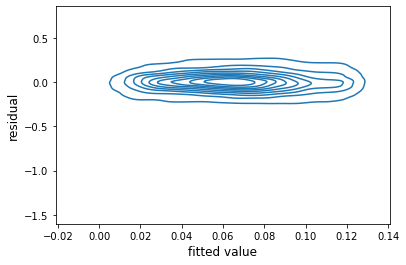

In [58]:
fit=fe_res.fitted_values.reset_index()['fitted_values'].tolist()
res=fe_res.resids.reset_index()['residual'].tolist()
sns.kdeplot(fit, res)
plt.xlabel("fitted value", fontsize=12)
plt.ylabel('residual', fontsize=12)
#plt.savefig('fit_res.pdf')

In [103]:
import seaborn as sns

In [93]:

plotdata=metadata.reset_index()

In [81]:
plotdata_filter=plotdata[plotdata.country.isin(cntrylist)]

In [47]:
metadata.columns

Index(['discipline', 'numpubs_x', 'numpubs_y', 'dom_unit', 'for_unit',
       'unit2for', 'pubcount_2for', 'numpubs', 'dom_coll', 'int_coll',
       'forei_count', 'domes_count', 'dom_unit_avg', 'foreign_unit_avg',
       'unit2for_avg', 'dom_coll_ratio', 'int_coll_ratio', 'pub_growth',
       'numpubs_x_log', 'dom_unit_log', 'for_unit_log', 'unit2for_log',
       'timesize', 'dom_coll_log', 'int_coll_log'],
      dtype='object')

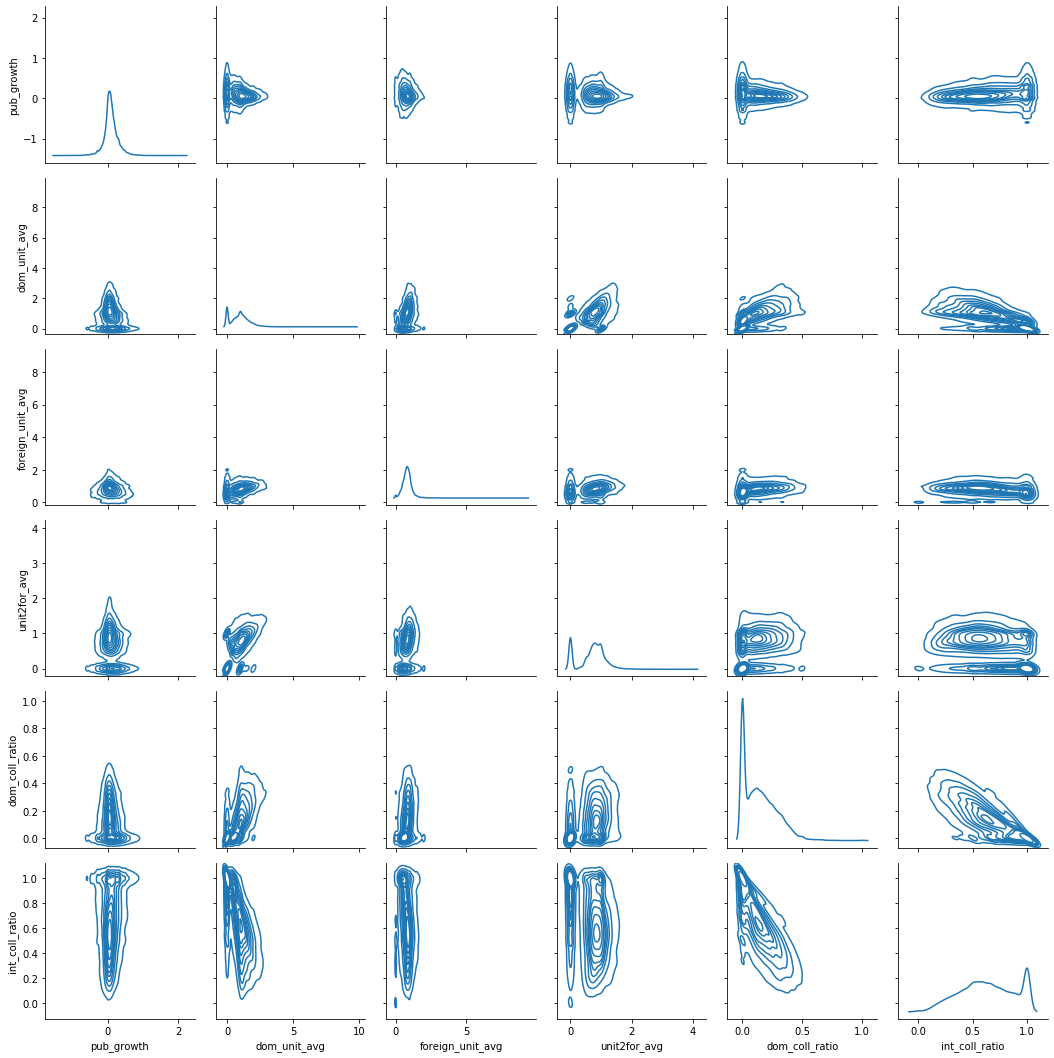

In [48]:
g = sns.PairGrid(metadata, vars=['pub_growth','dom_unit_avg','foreign_unit_avg','unit2for_avg','dom_coll_ratio','int_coll_ratio'])
g.map_upper(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
plt.savefig("reg_all_avg.png",bbox_inches='tight')

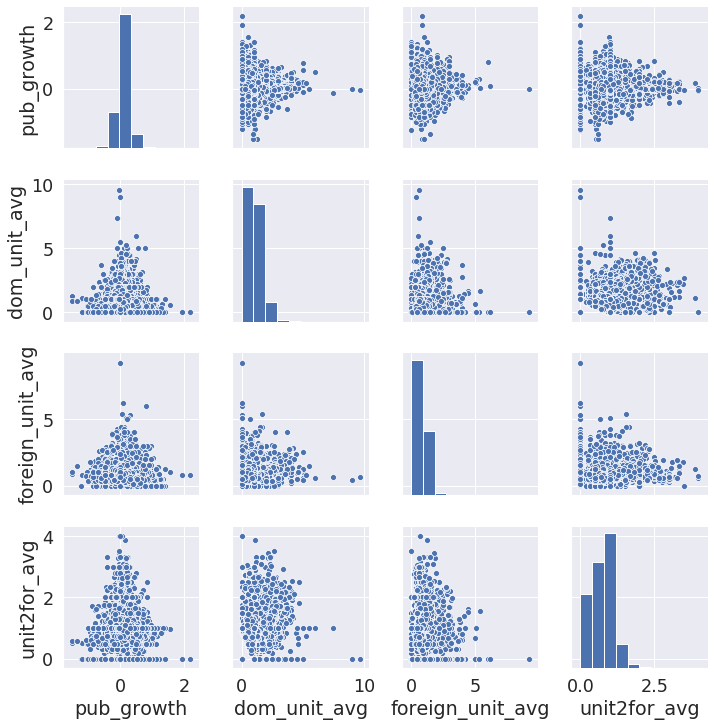

In [95]:
sns.set(font_scale=1.6)
sns.pairplot(metadata, vars=['pub_growth','dom_unit_avg','foreign_unit_avg','unit2for_avg'])
#plt.savefig('pairwise.png',bbox_inches='tight')

### archive code

In [ ]:
fund_df=pubs_author_funder[['id','funder_country','discipline','year']]
fund_df=fund_df[fund_df.funder_country!="Not-Funded"]
fund_df['funder_country']=fund_df['funder_country'].apply(lambda x:list(set(x)))
fund_df['cofund']=fund_df['funder_country'].apply(
    lambda x:1 if len(x)>1 else 0)
fund_df

In [ ]:
fund_df=fund_df.explode('funder_country')
fund_df.head()

In [ ]:
def get_fundcount(data, start, end):
    data_filter=data[data.year.isin(start)]
    data_filter = data_filter.groupby(['funder_country','discipline','cofund']).size().reset_index()
    data_filter=data_filter.pivot_table(
        index=['funder_country','discipline'],columns='cofund',fill_value=0)
    return data_filter

In [ ]:
yearwindow= window(np.arange(2009,2019), 6)
cntry_fundcount = construct_windowdata(fund_df,yearwindow,get_fundcount)
cntry_fundcount = cntry_fundcount.reset_index()
cntry_fundcount.columns=['country','discipline','singlefund','cofund','time']

In [ ]:
metadata=metadata.merge(cntry_fundcount,on=['country','discipline','time'], how='left')
metadata.head()

In [ ]:
#transform the data
metadata['pub_growth']=np.log10(metadata['numpubs_y']/metadata['numpubs_x'])
metadata['numpubs_x_log']=np.log10(metadata['numpubs_x'])
metadata['dom_unit_log']=np.log10(metadata['dom_unit']+1)
metadata['for_unit_log']=np.log10(metadata['for_unit']+1)
metadata['numpubs_y_log']=np.log10(metadata['numpubs_y'])
metadata['dom_coll_log']=np.log10(metadata['dom_coll']+1)
metadata['int_coll_log']=np.log10(metadata['int_coll']+1)
metadata['singlefund_log']=np.log10(metadata['singlefund']+1)
metadata['cofund_log']=np.log10(metadata['cofund']+1)